# Preparation

In [5]:
import os
import sys
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import tarfile
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from keras.preprocessing.sequence import pad_sequences
import math
import warnings

# ECG Anomaly Detection using Audoencoder 

https://anomagram.fastforwardlabs.com/#/

## Overview


In this example, you will train an autoencoder to detect anomalies on the [ECG5000 dataset](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000). This dataset contains 5,000 [Electrocardiograms](https://en.wikipedia.org/wiki/Electrocardiography), each with 140 data points. You will use a simplified version of the dataset, where each example has been labeled either `0` (corresponding to an abnormal rhythm), or `1` (corresponding to a normal rhythm). You are interested in identifying the abnormal rhythms.

Note: This is a labeled dataset, so you could phrase this as a supervised learning problem. The goal of this example is to illustrate anomaly detection concepts you can apply to larger datasets, where you do not have labels available (for example, if you had many thousands of normal rhythms, and only a small number of abnormal rhythms).

How will you detect anomalies using an autoencoder? Recall that an autoencoder is trained to minimize reconstruction error. You will train an autoencoder on the normal rhythms only, then use it to reconstruct all the data. Our hypothesis is that the abnormal rhythms will have higher reconstruction error. You will then classify a rhythm as an anomaly if the reconstruction error surpasses a fixed threshold.

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

**ECG5000 Dataset**
More info: http://www.timeseriesclassification.com/description.php?Dataset=ECG5000

The original dataset for "ECG5000" is a 20-hour long ECG downloaded from Physionet. The name is BIDMC Congestive Heart Failure Database(chfdb) and it is record "chf07". It was originally published in "Goldberger AL, Amaral LAN, Glass L, Hausdorff JM, Ivanov PCh, Mark RG, Mietus JE, Moody GB, Peng C-K, Stanley HE. PhysioBank, PhysioToolkit, and PhysioNet: Components of a New Research Resource for Complex Physiologic Signals. Circulation 101(23)". The data was pre-processed in two steps: (1) extract each heartbeat, (2) make each heartbeat equal length using interpolation. This dataset was originally used in paper "A general framework for never-ending learning from time series streams", DAMI 29(6). After that, 5,000 heartbeats were randomly selected. The patient has severe congestive heart failure and the class values were obtained by automated annotation

This is a sample of ECG5000 dataset in which each ECG has a length of 140 and the last column is associated with label.

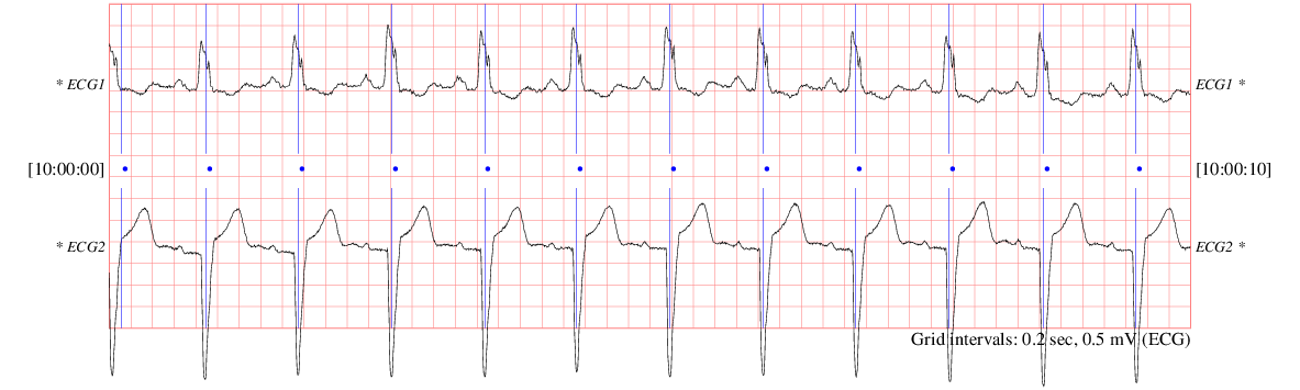

In [7]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818287,-1.250522,-0.477492,-0.363808,-0.491957,-0.421855,-0.309201,-0.495939,-0.342119,-0.355336,-0.367913,-0.316503,-0.412374,-0.471672,-0.413458,-0.364617,-0.449298,-0.471419,-0.424777,-0.462517,-0.552472,-0.475375,-0.694200,-0.701868,-0.593812,-0.660684,-0.713831,-0.769807,-0.672282,-0.653676,-0.639406,-0.559302,-0.591670,...,1.258179,1.433789,1.700533,1.999043,2.125341,1.993291,1.932246,1.797437,1.522284,1.251168,0.998730,0.483722,0.023132,-0.194914,-0.220917,-0.243737,-0.254695,-0.291136,-0.256490,-0.227874,-0.322423,-0.289286,-0.318170,-0.363654,-0.393456,-0.266419,-0.256823,-0.288694,-0.162338,0.160348,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,0.148951,0.183527,0.294876,0.190233,0.235575,0.253487,0.221742,0.050233,0.178042,0.139563,0.046794,0.043007,0.106544,0.012654,0.003995,0.045724,-0.045999,-0.072667,-0.071078,-0.153866,-0.227254,-0.249270,-0.253489,-0.332835,-0.264330,-0.345825,-0.310781,-0.334160,-0.306178,-0.174563,...,1.808428,2.164346,2.070747,1.903614,1.764455,1.507769,1.293428,0.894562,0.578016,0.244343,-0.286443,-0.515881,-0.732707,-0.832465,-0.803318,-0.836252,-0.777865,-0.774753,-0.733404,-0.721386,-0.832095,-0.711982,-0.751867,-0.757720,-0.853120,-0.766988,-0.688161,-0.519923,0.039406,0.560327,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490658,-1.183580,-0.394229,-0.282897,-0.356926,-0.287297,-0.399489,-0.473244,-0.379048,-0.399039,-0.178594,-0.339522,-0.498447,-0.337251,-0.425480,-0.423952,-0.463170,-0.493253,-0.549749,-0.529831,-0.530935,-0.502365,-0.417368,-0.526346,-0.471005,-0.676784,-0.898612,-0.610571,-0.530164,-0.765674,-0.581937,-0.537848,-0.556386,...,1.810988,2.185398,2.262985,2.052920,1.890488,1.793033,1.564784,1.234619,0.900302,0.551957,0.258222,-0.128587,-0.092585,-0.168606,-0.495989,-0.395034,-0.328238,-0.448138,-0.268230,-0.456415,-0.357867,-0.317508,-0.434112,-0.549203,-0.324615,-0.268082,-0.220384,-0.117429,0.614059,1.284825,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,-0.183319,-0.101657,-0.273874,-0.127818,-0.195983,-0.213523,-0.176473,-0.156932,-0.149172,-0.181510,-0.180074,-0.246151,-0.274260,-0.140960,-0.277449,-0.382549,-0.311937,-0.360093,-0.405968,-0.571433,-0.524106,-0.537886,-0.606778,-0.661446,-0.683375,-0.746683,-0.635662,-0.625231,-0.540094,-0.674995,...,1.772155,2.000769,1.925003,1.898426,1.720953,1.501711,1.422492,1.023225,0.776341,0.504426,0.056382,-0.233161,-0.406388,-0.327528,-0.460868,-0.402536,-0.345752,-0.354206,-0.439959,-0.425326,-0.439789,-0.451835,-0.395926,-0.448762,-0.391789,-0.376307,-0.461069,-0.253524,0.213006,0.491173,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,-0.298107,-0.428928,-0.491351,-0.361304,-0.339296,-0.324952,-0.290113,-0.363051,-0.525684,-0.597423,-0.575523,-0.567503,-0.504555,-0.618406,-0.682814,-0.743849,-0.815588,-0.826902,-0.782374,-0.929462,-0.999672,-1.060969,-1.007877,-1.028735,-1.122629,-1.028650,-1.046515,-1.063372,-1.122423,-0.983242,...,1.155363,1.336254,1.627534,1.717594,1.696487,1.741686,1.674078,1.546928,1.331738,1.110168,0.922210,0.521777,0.154852,-0.123861,-0.202998,-0.247956,-0.219122,-0.214695,-0.319215,-0.198597,-0.151618,-0.129593,-0.074939,-0.

In [8]:
# The last element contains the labels
labels = raw_data[:, -1].astype(bool)

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

normal_data = data[labels]
anomalous_data = data[~labels]

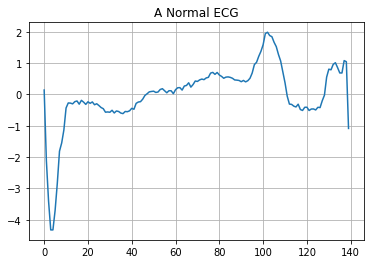

In [9]:
plt.grid()
plt.plot(np.arange(140), normal_data[500])
plt.title("A Normal ECG")
plt.show()

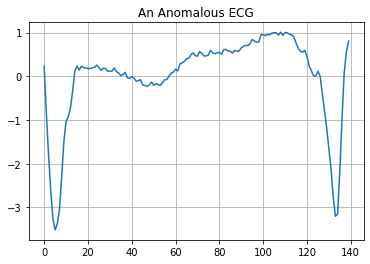

In [10]:
plt.grid()
plt.plot(np.arange(140), anomalous_data[500])
plt.title("An Anomalous ECG")
plt.show()

Normalize the data to [0,1].

In [11]:
train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

You will train the autoencoder using only the normal rhythms, which are labeled in this dataset as 1. Separate the normal rhythms from the abnormal rhythms.

In [12]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

Build a model

In [13]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

Notice that the autoencoder is trained using only the normal ECGs, but is evaluated using the full test set.

In [14]:
autoencoder.compile(optimizer='adam', loss='mae')
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 0s 30ms/step - loss: 0.0576 - val_loss: 0.0530
Epoch 2/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0548 - val_loss: 0.0519
Epoch 3/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0513 - val_loss: 0.0492
Epoch 4/20
5/5 [==============================] - 0s 8ms/step - loss: 0.0475 - val_loss: 0.0471
Epoch 5/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0440 - val_loss: 0.0452
Epoch 6/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0407 - val_loss: 0.0433
Epoch 7/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0377 - val_loss: 0.0418
Epoch 8/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0349 - val_loss: 0.0404
Epoch 9/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0326 - val_loss: 0.0391
Epoch 10/20
5/5 [==============================] - 0s 6ms/step - loss: 0.0306 - val_loss: 0.0381
Epoch 11/20
5/5 [=====================

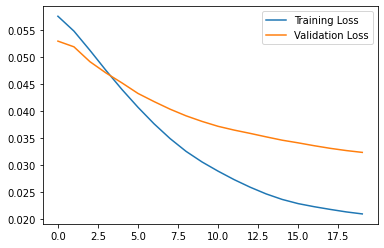

In [15]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

You will soon classify an ECG as anomalous if the reconstruction error is greater than one standard deviation from the normal training examples. First, let's plot a normal ECG from the training set, the reconstruction after it's encoded and decoded by the autoencoder, and the reconstruction error.

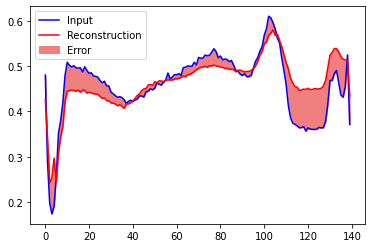

In [16]:
encoded_imgs = autoencoder.encoder(normal_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(normal_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], normal_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Create a similar plot, this time for an anomalous test example.

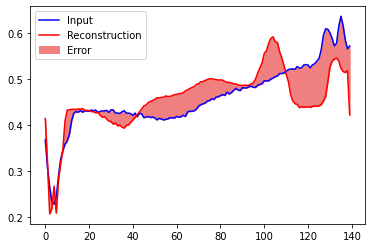

In [17]:
encoded_imgs = autoencoder.encoder(anomalous_test_data).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

plt.plot(anomalous_test_data[0],'b')
plt.plot(decoded_imgs[0],'r')
plt.fill_between(np.arange(140), decoded_imgs[0], anomalous_test_data[0], color='lightcoral' )
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

Detect anomalies by calculating whether the reconstruction loss is greater than a fixed threshold. In this tutorial, you will calculate the mean average error for normal examples from the training set, then classify future examples as anomalous if the reconstruction error is higher than one standard deviation from the training set.

Plot the reconstruction error on normal ECGs from the training set

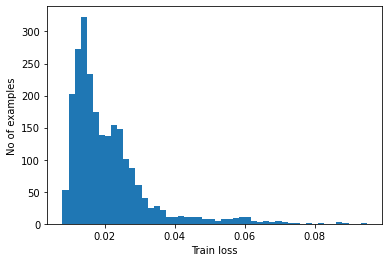

In [18]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss, bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

Choose a threshold value that is one standard deviations above the mean.

In [19]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.0321135


Note: There are other strategies you could use to select a threshold value above which test examples should be classified as anomalous, the correct approach will depend on your dataset. You can learn more with the links at the end of this tutorial.

If you examine the recontruction error for the anomalous examples in the test set, you'll notice most have greater reconstruction error than the threshold. By varing the threshold, you can adjust the precision and recall of your classifier.

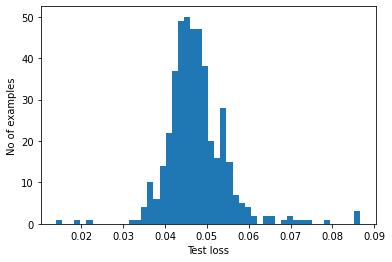

In [20]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss, bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

Classify an ECG as an anomaly if the reconstruction error is greater than the threshold.

In [21]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, preds)))
  print("Precision = {}".format(precision_score(labels, preds)))
  print("Recall = {}".format(recall_score(labels, preds)))

In [ ]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.945
Precision = 0.9922027290448343
Recall = 0.9089285714285714
